## HUMAN STATS DISTRIBUTION
- Plots the distribution of spatial information and ANOVA F-statistics for human place cells
- Example Cells

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from convnwb.io import get_files, load_jsons_to_df
from scipy.stats import binom_test

from spiketools.plts.utils import make_grid, get_grid_subplot, save_figure
from spiketools.plts.style import drop_spines
from spiketools.utils.run import create_methods_list

In [2]:
import seaborn as sns
sns.set_context('talk', font_scale=0.9)

In [3]:

import sys
sys.path.append('../code')
from plts import plot_raster_with_tuning_curve
sys.path.append('../scripts')
from settings import PATHS, METHODS

In [4]:
results_folder = PATHS['RESULTS'] / 'units'
reports_folder = PATHS['REPORTS'] / 'units'


In [5]:
# Get the list of files
res_files = get_files(results_folder, select='mat')

In [6]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=results_folder)

In [7]:
# Check the columns
all_results.columns

Index(['unit_ind', 'session_id', 'label', 'spike_name', 'place_bins',
       'spike_position', 'trial_changes', 'trial_Num', 'trial_place_bins',
       'place_sem', 'trial_fr', 'fr_bins', 'fr_sem', 's_bins', 'place_info',
       'place_fr_info', 'place_anova', 'place_fr_anova',
       'place_anova_surr_p_val', 'place_anova_surr_z_score',
       'place_info_surr_p_val', 'place_info_surr_z_score',
       'place_fr_anova_surr_p_val', 'place_fr_anova_surr_z_score',
       'place_fr_info_surr_p_val', 'place_fr_info_surr_z_score'],
      dtype='object')

## Dropped Neurons 

In [8]:
from copy import deepcopy

# Display the original dataframe before filtering
print("Original dataframe shape:", all_results.shape)
print(all_results.columns)
all_results['firing_rate'] = all_results['place_bins'].apply(lambda x: np.mean(x))
all_results['presence_ratio'] = all_results['trial_fr'].apply(lambda x: np.mean([np.any(np.array(trial) > 0) for trial in x]))
# Create a filtered copy
results = deepcopy(all_results)

results = results[all_results['firing_rate'].astype(float) < 20]
results = results[all_results['firing_rate'].astype(float) > .15]
results = results[all_results['presence_ratio'].astype(float) > .2]
# Display the filtered dataframe
print("\nFiltered dataframe shape:", results.shape)


Original dataframe shape: (390, 26)
Index(['unit_ind', 'session_id', 'label', 'spike_name', 'place_bins',
       'spike_position', 'trial_changes', 'trial_Num', 'trial_place_bins',
       'place_sem', 'trial_fr', 'fr_bins', 'fr_sem', 's_bins', 'place_info',
       'place_fr_info', 'place_anova', 'place_fr_anova',
       'place_anova_surr_p_val', 'place_anova_surr_z_score',
       'place_info_surr_p_val', 'place_info_surr_z_score',
       'place_fr_anova_surr_p_val', 'place_fr_anova_surr_z_score',
       'place_fr_info_surr_p_val', 'place_fr_info_surr_z_score'],
      dtype='object')

Filtered dataframe shape: (284, 28)


/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_57046/215291203.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results = results[all_results['firing_rate'].astype(float) > .15]
/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_57046/215291203.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results = results[all_results['presence_ratio'].astype(float) > .2]


## Check Results 

In [9]:
# Get total number of units
n_units = len(all_results)
print('Total number of cells: {}'.format(n_units))

Total number of cells: 390


In [10]:
analyses = create_methods_list(METHODS)
# Statistics settings
alpha_level = 0.05
binom_sidedness = 'greater'    # 'two-sided', 'greater', 'less'

In [11]:
#results_folder = PATHS['RESULTS'] / 'units_matlab'

In [12]:

#     print(all_results[f'{analysis}_surr_p_val'])
   # Collect numbers of significant cells
results = {}
for analysis in analyses:
    all_results[f'is_{analysis}'] = (all_results[f'{analysis}_surr_p_val'] < alpha_level).values #results[analysis] = sum(all_results['is_' + analysis])

In [13]:
for analysis in analyses:
     results[analysis] = sum(all_results['is_' + analysis])

In [14]:
# Compute significance of the counts of detected neurons
stats = {}
for analysis in analyses:
    stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)

/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_57046/2198180662.py:4: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)


In [15]:
# Check the number & percent of significant cells per analysis
print('total cells: {}\n'.format( n_units))
for analysis in analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%) \t\t {:.4f}'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100, stats[analysis]))

total cells: 390

# place_anova cells:     		 85  (21.79%) 		 0.0000
# place_info cells:     		 84  (21.54%) 		 0.0000
# place_fr_anova cells:     		 54  (13.85%) 		 0.0000
# place_fr_info cells:     		 63  (16.15%) 		 0.0000


## Group Level Analysis 

In [16]:
df_cleaned = all_results.dropna()
place_info = df_cleaned['place_fr_info']
place_anova = df_cleaned['place_fr_anova']
place_info_surr_p_val =  df_cleaned['place_fr_info_surr_p_val']
place_anova_surr_p_val =  df_cleaned['place_fr_anova_surr_p_val']


In [17]:
SI = all_results['place_fr_info']
F = all_results['place_fr_anova']

si_pval =  all_results['place_fr_info_surr_p_val']
anova_pval =  all_results['place_fr_anova_surr_p_val']

In [18]:
len(F[anova_pval < 0.05])

54

In [19]:
threshold = 0.05

In [20]:
sorted_anova = all_results.sort_values(by='place_fr_anova', ascending=False)
sorted_anova = sorted_anova.reset_index(drop=True)

sorted_si = all_results.sort_values(by='place_fr_info', ascending=False)
sorted_si = sorted_si.reset_index(drop=True)

f_max = sorted_anova.index[0]
si_max = sorted_si.index[15]
si_median = all_results.index[len(all_results) // 4]-3



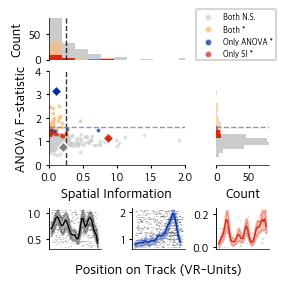

In [40]:
# Create a figure with a main scatter plot and a histogram on the right side
anova_bins = np.linspace(0, 10, 50)
info_bins = np.linspace(0, max(place_info) * 1.05, 50)
threshold = 0.05
grid = make_grid(5, 5, wspace=.6, hspace=0.3, height_ratios = [1, 1, 1, .5, 1], figsize=(5, 3),
                 )

plt.rcParams.update({
    'font.family': 'Apple SD Gothic Neo',
    'font.size': 10,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,  # Smaller tick label size
    'ytick.labelsize': 8,  # Smaller tick label size
    'axes.linewidth': 0.5,  # Reduce the thickness of axis lines
    'xtick.major.width': 0.8,  # Thinner x ticks
    'ytick.major.width': 0.8,  # Thinner y ticks
    'xtick.major.size': 2.0,   # Shorter x ticks
    'ytick.major.size': 2.0    # Shorter y ticks
})
# Get subplots from the grid
ax_top = get_grid_subplot(grid, 0, slice(0, 2))
ax_main = get_grid_subplot(grid, slice(1, 3), slice(0, 2))
ax_hist = get_grid_subplot(grid, slice(1, 3), 2)


anova_bins = np.linspace(0, np.max(place_anova), 20)
info_bins = np.linspace(0, np.max(place_info), 20)

# Define masks for different categories
mask = (place_anova_surr_p_val < threshold) & (place_info_surr_p_val < threshold)
info_mask = (place_info_surr_p_val < threshold) & (place_anova_surr_p_val >= threshold)
anova_mask = (place_info_surr_p_val >= threshold) & (place_anova_surr_p_val < threshold)
non_sig_mask = (place_info_surr_p_val >= threshold) & (place_anova_surr_p_val >= threshold)

# Colors for different categories
non_sig_color = '#cccccc'
anova_color = '#002FA7'  # Deep blue for ANOVA
info_color = '#D92911' 
both_color = '#FDB76D'

# Set x-axis limit for both main and top plots
x_max = max(place_info) * 1.05

# Main scatter plot
ax_main.scatter(place_info[non_sig_mask], place_anova[non_sig_mask], alpha=.5, color=non_sig_color, s=2, label='Both N.S.')  # Increased point size
ax_main.scatter(place_info[mask], place_anova[mask], alpha=0.6, color=both_color, s=2, label='Both *')  # Increased point size
ax_main.scatter(place_info[anova_mask], place_anova[anova_mask], alpha=0.6, color=anova_color, s=2, label='Only ANOVA *')  # Increased point size
ax_main.scatter(place_info[info_mask], place_anova[info_mask], alpha=0.6, color=info_color, s=2, label='Only SI *')  # Increased point size


# Histogram on the right side

ax_hist.hist(place_anova[non_sig_mask], bins=anova_bins, color=non_sig_color, alpha=1, orientation='horizontal')
ax_hist.hist(place_anova[mask], bins=anova_bins, color=both_color, alpha=0.6, orientation='horizontal')
ax_hist.hist(place_anova[anova_mask], bins=anova_bins, color=anova_color, alpha=0.5, orientation='horizontal')
ax_hist.hist(place_anova[info_mask], bins=anova_bins, color=info_color, alpha=1, orientation='horizontal')
ax_hist.set_xlim(0, 80)
# Histogram on the top
ax_top.hist(place_info[non_sig_mask], bins=info_bins, color=non_sig_color, alpha=1, orientation='vertical')
ax_top.hist(place_info[mask], bins=info_bins, color=both_color, alpha=0.6, orientation='vertical')
ax_top.hist(place_info[anova_mask], bins=info_bins, color=anova_color, alpha=0.5, orientation='vertical')
ax_top.hist(place_info[info_mask], bins=info_bins, color=info_color, alpha=1, orientation='vertical')
ax_top.set_xlabel('')
ax_top.set_xlim(0,2)  # Explicitly set the same x-axis limits as main plot
ax_top.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_top.set_ylim(0, 80)
drop_spines(['top','right','bottom'], ax=ax_top)

 
# Hide y-axis labels for the histogram
ax_main.set_xlabel('Spatial Information')  # Increased label font size
ax_main.set_ylabel('ANOVA F-statistic')  # Increased label font size
ax_main.set_xlim(0, 2)
ax_main.set_ylim(0, 4)
ax_hist.set_xlabel('Count')  # Increased label font size
ax_hist.set_ylabel('')
ax_hist.set_ylim(0, 4)

ax_hist.tick_params(axis='y', which='both', left=False, labelleft=False)
ax_top.set_ylabel('Count')  # Increased label font size

# Increase tick label font sizes
ax_main.tick_params(axis='both', which='major')  # Increased tick font size
ax_hist.tick_params(axis='both', which='major')  # Increased tick font size
ax_top.tick_params(axis='both', which='major')  # Increased tick font size


drop_spines(['top','right'], ax=ax_main)
drop_spines(['top','right','left'], ax=ax_hist)

ax_hist.axhline(1.6, color='grey', lw=1, linestyle='--', alpha=0.8)  # Increased line width
ax_main.axvline(0.25, color='black', lw=1, linestyle='--', alpha=0.8)  # Increased line width
ax_top.axvline(0.25, color='black', lw=1, linestyle='--', alpha=0.8)  # Increased line width
ax_main.axhline(1.6, color='grey', lw=1, linestyle='--', alpha=0.8)  # Increased line width
ax_main.legend(bbox_to_anchor=(1.7, 1.7), frameon=True, fontsize=6, markerscale=2)


ax = get_grid_subplot(grid, 4, 0)
plot_raster_with_tuning_curve(all_results, si_median,ax=ax,curve_color='black')

ax = get_grid_subplot(grid, 4, 1)
plot_raster_with_tuning_curve(sorted_anova, f_max,ax=ax,curve_color=anova_color)
ax.set_xlabel('Position on Track (VR-Units)', labelpad=10)


ax = get_grid_subplot(grid, 4, 2)
plot_raster_with_tuning_curve(sorted_si, si_max,ax=ax,curve_color=info_color)


# Make scatter plots more prominent with larger size, thicker borders, and higher zorder
ax_main.scatter(sorted_anova['place_fr_info'].iloc[f_max], sorted_anova['place_fr_anova'].iloc[f_max],
    c=anova_color, s=30, alpha=1, marker='D', label='High F', zorder=20,edgecolor='white', linewidth=1, 
)
# Add annotation for High F point
# ax_main.annotate('High F', 
#                 xy=(sorted_anova['place_info'].iloc[f_max], sorted_anova['place_anova'].iloc[f_max]),
#                 xytext=(10, 10), textcoords='offset points',
               
#                 bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7))

ax_main.scatter(sorted_si['place_fr_info'].iloc[si_max], sorted_si['place_fr_anova'].iloc[si_max],
    c=info_color, s=30, alpha=1, marker='D',   label='High SI', zorder=20,edgecolor='white', linewidth=1, 
)
# Add annotation for High SI point
# ax_main.annotate('High SI', 
#                 xy=(sorted_si['place_info'].iloc[si_max], sorted_si['place_anova'].iloc[si_max]),
#                 xytext=(10, 20), textcoords='offset points',
               
#                 bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7))

ax_main.scatter(sorted_si['place_fr_info'].iloc[si_median], sorted_si['place_fr_anova'].iloc[si_median],
    c='grey', s=30, alpha=1, marker='D', label='Median SI', zorder=20, edgecolor='white', linewidth=1, 
    clip_on=False  # Prevent the marker from being clipped by the plot edge
)
# Add annotation for Median SI point
# ax_main.annotate('Median F & SI', 
#                 xy=(sorted_si['place_info'].iloc[si_median], sorted_si['place_anova'].iloc[si_median]),
#                 xytext=(20, -20), textcoords='offset points',
               
#                 bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7))





save_figure('Human_Distribution', file_path='/Users/weijiazhang/Plots/PLDM/Human',dpi=300)

In [22]:
# Calculate basic statistics
print("Place ANOVA range:", min(place_anova), "to", max(place_anova))
print("Place Info range:", min(place_info), "to", max(place_info))

Place ANOVA range: 0.4296939955523356 to 3.1155323636353627
Place Info range: 0.0028178827257196934 to 3.6349123502760547


In [23]:
results['place_fr_anova'].describe()

AttributeError: 'int' object has no attribute 'describe'